### Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re

### Read the dataset

In [2]:
filename = 'Project (Application 1) (MetuSabanci Treebank).conll'

sentences = []
with open(filename, encoding="utf-8-sig") as infh:
    sentence = []
    for line in infh:
        if len(line) == 1:
            sentences.append(sentence.copy())
            sentence = []
        else:
            line_split = line.strip().split('\t')
            if line_split[1] != '_':
                if line_split[1].lower() == 'satın': # An error in the corpus that should be fixed by using POS 'Noun'
                    sentence.append([line_split[1], 'Noun'])
                else:
                    sentence.append([line_split[1], line_split[3]])

### Split the data into training and test sets

In [3]:
np.random.shuffle(sentences)
train_size = round(len(sentences)*0.9)
training = sentences[:train_size]
test = sentences[train_size:]

### Train the model

In [65]:
# Train seperate classifiers for the following features
# a non-first word whose first letter is capital (e.g. Ahmet -> Noun)
def non_first_capital_word_checker(word, **kwargs):
    return 'first_token' in kwargs and not kwargs['first_token'] and word[0] == word[0].upper()
# ends with -ıp, -ip, -up etc. (e.g. kurtulup, yapıp, edip etc. -> adj)
def endswith_up_checker(word, **kwargs):
    return re.search(r'.+[ıiuü]p$', word) is not None
# ends with -rdı, -rdi, -rdik, -rdim etc. (e.g. yapardı, koşardı, getirdik, ettim etc. -> verb)
def endswith_rdik_checker(word, **kwargs):
    return re.search(r'.+rd[ıiuü][mk]*$', word) is not None
# ends with -ı, -i, -yı, -yi etc. (e.g. yapmayı, götürüyü etc. -> noun)
def endswith_yi_checker(word, **kwargs):
    return re.search(r'y?[ıiuü]$', word) is not None
# ends with -mış, -miş, -mışsınız, -mişiz etc. (e.g. yapmışız, koşmuşuz etc. -> verb)
def endswith_mis_checker(word, **kwargs):
    return re.search(r'.+m[ıiuü]ş([ıiuü]m|s[ıiuü]n([ıiuü]z)?|[ıiuü]z|l[ea]r)?$', word) is not None
    #return re.search(r'm[ı,i,u,ü]ş[s]*[ı,i,u,ü]*[n]*[ı,i,u,ü]*[z]*$', word) is not None
# ends with -dı, -di, -diler, -tünüz etc. (e.g. yaptık, koştular etc. -> verb)
def endswith_di_checker(word, **kwargs):
    return re.search(r'.+[dt][ıiuü](m|n|k|n[ıiuü]z|l[ea]r)?$', word) is not None
    #return re.search(r'[d,t][ı,i,u,ü][l]*[e,a]*[r]*[k]*[n]*[ı,i,u,ü]*[z]*$', word) is not None
# ends with -ca, -ce etc. (e.g. kısaca, kabaca etc. -> adv)
def endswith_ca_checker(word, **kwargs):
    return re.search(r'.+[cç][ae]$', word) is not None
# ends with -la, -yle etc. (e.g. benle, eliyle etc. -> adv)
def endswith_yla_checker(word, **kwargs):
    return re.search(r'.+y?l[ae]$', word) is not None
# ends with -ecek, -acak etc. (e.g. edeceğiz, yapacaklar etc. -> verb)
def endswith_acak_checker(word, **kwargs):
    return re.search(r'.+(aca|ece)(ğ[ıi][mz]|ks[ıi]n([ıi]z)?|k(l[ea]r)?)$', word) is not None
    #return re.search(r'[a,e]c[a,e][ğ,k][s]*[l]*[a,e,ı,i]*[r]*[n]*[ı,i]*[z]*[m]*$', word) is not None
# ends with -an, -en etc. (e.g. yapan, edenleri etc. -> adv)
def endswith_an_checker(word, **kwargs):
    return re.search(r'[ae]n[l]*[ae]*[r]*[ıi]*$', word) is not None
# ends with -e, -a, -de, -da, -den, -ten etc.
def endswith_a_checker(word, **kwargs):
    return re.search(r'[l]*[a,e]*[r]*[aeıiuü][yl]*[mn]*[ıiuü]*[z]*[dt]*[ae]*[n]*$', word) is not None
# ends with -lerine, -mize etc. (e.g. kendimize, kendilerine etc. -> adv)
def endswith_ine_checker(word, **kwargs):
    return re.search(r'[l]*[ae]*[r]*[ıi]*[mn][aeıi][z]*[ae]*$', word) is not None
# ends with -şme, -şma etc. (e.g. sürtüşme, kapışma etc. -> noun)
def endswith_sme_checker(word, **kwargs):
    return re.search(r'.+şm[ae][l]*[ae]*[r]*[ıi]*[n]*$', word) is not None
# ends with -me, -ma, -mek, -mak etc. (e.g. etme, yapmak etc. -> noun)
def endswith_ma_checker(word, **kwargs):
    return re.search(r'.+m[ae][k]?$', word) is not None
# ends with -siz, -suz etc. (e.g. sessiz, susuz etc. -> adj)
def endswith_siz_checker(word, **kwargs):
    return re.search(r'.+s[ıiuü]z$', word) is not None
# ends with -li -lu etc. (e.g. sesli, sulu etc. -> adj)
def endswith_li_checker(word, **kwargs):
    return re.search(r'.+l[ıiuü]$', word) is not None
# ends with -(n)in etc. (e.g. şişenin, masanın etc. -> noun)
def endswith_nin_checker(word, **kwargs):
    return re.search(r'.+n?[ıiuü]n$', word) is not None
# ends with -(n)da etc. (e.g. sonunda, içinde etc. -> noun)
def endswith_nda_checker(word, **kwargs):
    return re.search(r'.+nd[ae]$', word) is not None
# ends with -de, -den etc. (e.g. evden, bende etc. -> noun)
def endswith_deden_checker(word, **kwargs):
    return re.search(r'.+d[ae]n?$', word) is not None
# ends with -se -sa etc. (e.g. gelse, yapsalar)
def endswith_sa_checker(word, **kwargs):
    return re.search(r'.+s[ea](m|n([ıi]z)?|k|l[ea]r)?$', word) is not None
# ends with -se -sa etc. (e.g. gelse, yapsalar)
def endswith_dir_checker(word, **kwargs):
    return re.search(r'.+[dt][ıiuü]r$', word) is not None
# contains hyphen
def contains_hyphen_checker(word, **kwargs):
    return re.search(r'.+\'.+', word) is not None
# allcaps
def is_all_caps(word, **kwargs):
    return re.search(r'^[A-ZÇÖİŞÜĞ]+$', word) is not None

def endswith_yor_checker(word, **kwargs):
    return re.search(r'.+[ıiuü]?yor(um|sun|uz|sunuz|lar)?$', word) is not None

# precursor of questions
def startswith_mi_checker(word, **kwargs):
    return re.search(r'^m[ıiuü]', word) is not None

# derivational morphology for Verb->Adv change (-ken, -alı, -madan, -ince, -ip, -arak, -la, -dıkça)
def endswith_erek_checker(word, **kwargs):
    return re.search(r'.+(erek|arak)$', word) is not None

def endswith_dikca_checker(word, **kwargs):
    return re.search(r'.+[dt]([iü]kçe|[ıu]kça)$', word) is not None

def endswith_madan_checker(word, **kwargs):
    return re.search(r'.+m(ada|ede)n$', word) is not None

def endswith_ken_checker(word, **kwargs):
    return re.search(r'.+y?ken$', word) is not None

features = [non_first_capital_word_checker, endswith_up_checker, endswith_rdik_checker, 
            endswith_mis_checker, endswith_di_checker, endswith_ca_checker, endswith_acak_checker,
            endswith_an_checker, endswith_ine_checker, endswith_sme_checker, endswith_ma_checker,
            endswith_dir_checker, 
            endswith_siz_checker, endswith_li_checker, endswith_sa_checker, endswith_deden_checker,
            contains_hyphen_checker, endswith_yla_checker, endswith_nin_checker, endswith_nda_checker,
            endswith_yor_checker, startswith_mi_checker, endswith_erek_checker,
            endswith_dikca_checker, endswith_madan_checker,
            endswith_ken_checker, is_all_caps ]

unknown_probs_d = {'Adj': 0.10, 'Adv': 0.10, 'Interj': 0.05, 'Dup': 0.05, 'Num': 0.05, 
                   'Verb': 0.30, 'Noun': 0.40, 'Conj': 0.01, 'Det': 0.001, 
                   'Postp': 0.05, 'Punc': 0.001, 'Zero': 0.001, 'Pron': 0.10, 'Ques': 0.01}

In [66]:
# Extract the possible POS tags and Tokens in the training set into two sets
POS_tags = set()
tokens = set()
for sentence in training:
    for token, tag in sentence:
        POS_tags.add(tag)
        tokens.add(token)
        
# Convert tag and token sets into lists to have reference indices per tag/token
POS_tags = list(POS_tags)
tokens = list(tokens)

# Create and fill the transition and observation probability matrices
transition_probs = np.zeros((len(POS_tags)+1, len(POS_tags))) # +1 represents <s> (sentence beginning)
observation_probs = np.zeros((len(POS_tags), len(tokens)))
t_1_counts = np.zeros(len(POS_tags)+1)
t_counts = np.zeros(len(POS_tags))
feature_probs = np.zeros((len(POS_tags), len(features)))

for sentence in training:
    last_tag = '<s>'
    first_token = True
    for token, tag in sentence:
        t_1 = 0 if last_tag == '<s>' else POS_tags.index(last_tag) + 1
        t = POS_tags.index(tag)
        transition_probs[t_1, t] += 1
        t_1_counts[t_1] += 1
        t_counts[t] += 1
        
        w = tokens.index(token)
        observation_probs[t, w] += 1
        
        for feature in features:
            if feature(token, first_token=first_token):
                f = features.index(feature)
                feature_probs[t, f] += 1
        
        last_tag = tag
        
        if first_token:
            first_token = False
        
transition_probs = (transition_probs.T/t_1_counts).T
observation_probs = (observation_probs.T/t_counts).T
feature_probs = (feature_probs.T/t_counts).T
unknown_probs = [unknown_probs_d[POS] for POS in POS_tags]

### Test the model

In [67]:
def get_token_likelihood(state, token, b, first_token=False):
    if token in tokens:
        return b[state, tokens.index(token)]
    w = unknown_probs[state]
    for feature in features:
        if feature(token, first_token=first_token):
            f = features.index(feature)
            w = w * feature_probs[state, f]
    return w

def viterbi(states, observations, a, b):
    v = np.zeros((len(states)+2, len(observations)))
    backpointer = np.zeros((len(states)+2, len(observations))).astype(np.int)
    
    for s in range(1,len(states)+1):
        v[s,0] = a[0,s-1] * get_token_likelihood(s-1, observations[0], b, first_token=True)
        backpointer[s,0] = 0
    
    for t, o in enumerate(observations):
        if t == 0: continue
        for s in range(1,len(states)+1):
            v_max = -1
            v_argmax = -1
            bs = get_token_likelihood(s-1, o, b)
            for s_prime in range(1,len(states)+1):
                v_curr = v[s_prime,t-1] * a[s_prime,s-1] * bs
                if v_curr > v_max:
                    v_max = v_curr
                    v_argmax = s_prime
            v[s,t] = v_max
            backpointer[s,t] = v_argmax
    
    v[len(states)+1,len(observations)-1] = np.max(v[:,len(observations)-1])
    backpointer[len(states)+1,len(observations)-1] = max(1, np.argmax(v[:,len(observations)-1]))
    
    trace = []
    bp = backpointer[len(states)+1,len(observations)-1]
    row = len(states)+1
    column = len(observations)-1
    while row != 0:
        bp = backpointer[row, column]
        trace = [bp-1] + trace
        if row != len(states)+1:
            column = column - 1
        row = bp
    
    return [states[state_idx] for state_idx in trace[1:]]

In [68]:
correct_sentence = 0
confusion_matrix = np.zeros((len(POS_tags), len(POS_tags)))

examples = []
for t in test:
    pred=viterbi(POS_tags, list(map(lambda x:x[0], t)), transition_probs, observation_probs)
    gold=list(map(lambda x:x[1], t))
    
    examples += [(t[h][0], gold[h], pred[h]) for h in range(len(gold))]
    
    for tag_idx, gold_tag in enumerate(gold):
        confusion_matrix[POS_tags.index(gold_tag), POS_tags.index(pred[tag_idx])] += 1
        
    curr_correct = np.sum([1 if gold[i] == pred[i] else 0 for i in range(len(gold))])
    
    if len(gold) == curr_correct:
        correct_sentence += 1
    
tag_based_accuracy = np.trace(confusion_matrix) / np.sum(np.sum(confusion_matrix))
sentence_based_accuracy = correct_sentence / len(test)

print('Overall tag-based accuracy on test set:', tag_based_accuracy)
print('Sentence-based accuracy on test set:', sentence_based_accuracy)
print('----')
for i in range(len(POS_tags)):
    print('Accuracy for tag "{}" on test set:'.format(POS_tags[i]), confusion_matrix[i,i] / np.sum(confusion_matrix[i,:]))

Overall tag-based accuracy on test set: 0.9195035460992907
Sentence-based accuracy on test set: 0.4991119005328597
----
Accuracy for tag "Num" on test set: 0.6086956521739131
Accuracy for tag "Punc" on test set: 1.0
Accuracy for tag "Zero" on test set: nan
Accuracy for tag "Adv" on test set: 0.8561643835616438
Accuracy for tag "Det" on test set: 0.9842105263157894
Accuracy for tag "Noun" on test set: 0.9592021758839528
Accuracy for tag "Adj" on test set: 0.6914498141263941
Accuracy for tag "Pron" on test set: 0.9117647058823529
Accuracy for tag "Dup" on test set: 1.0
Accuracy for tag "Verb" on test set: 0.8848314606741573
Accuracy for tag "Conj" on test set: 0.9661016949152542
Accuracy for tag "Ques" on test set: 0.8666666666666667
Accuracy for tag "Interj" on test set: 0.6
Accuracy for tag "Postp" on test set: 0.8899082568807339


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


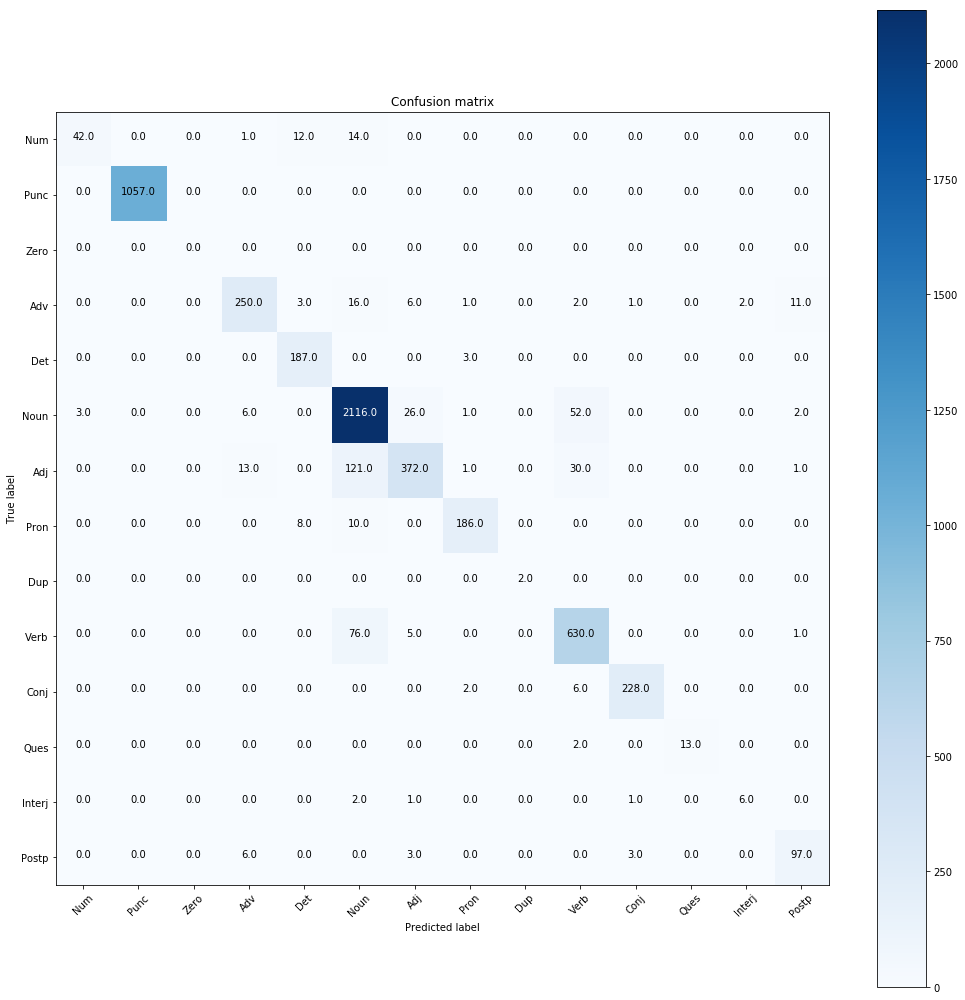

In [69]:
plt.figure(figsize=(14, 14))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.colorbar()

threshold = confusion_matrix.max() / 2
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, "{}".format(confusion_matrix[i, j]), horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > threshold else "black")

plt.tight_layout()
plt.xticks(np.arange(len(POS_tags)), POS_tags, rotation=45)
plt.yticks(np.arange(len(POS_tags)), POS_tags)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')
plt.show()

In [32]:
list(filter(lambda e: e[1]=='Postp' and e[2]=='Adj' ,examples))

[('başka', 'Postp', 'Adj'),
 ('doğru', 'Postp', 'Adj'),
 ('doğru', 'Postp', 'Adj')]

In [31]:
list(filter(lambda e: e[1]=='Postp' and e[2]=='Conj' ,examples))

[('ile', 'Postp', 'Conj'), ('ise', 'Postp', 'Conj'), ('ile', 'Postp', 'Conj')]

In [30]:
list(filter(lambda e: e[1]=='Ques' and e[2]=='Verb' ,examples))

[('muydu', 'Ques', 'Verb'), ('miydin', 'Ques', 'Verb')]

In [34]:
list(filter(lambda e: e[1]=='Adj' and e[2]=='Adv' ,examples))

[('çok', 'Adj', 'Adv'),
 ('çok', 'Adj', 'Adv'),
 ('Çok', 'Adj', 'Adv'),
 ('İyi', 'Adj', 'Adv'),
 ('Az', 'Adj', 'Adv'),
 ('delice', 'Adj', 'Adv'),
 ('kuşkusuz', 'Adj', 'Adv'),
 ('şöyle', 'Adj', 'Adv'),
 ('yok', 'Adj', 'Adv'),
 ('biraz', 'Adj', 'Adv'),
 ('açık', 'Adj', 'Adv'),
 ('böyle', 'Adj', 'Adv'),
 ('Karşı', 'Adj', 'Adv')]

In [52]:
list(filter(lambda e: e[1]=='Pron' and e[2]=='Noun' ,examples))

[('neden', 'Pron', 'Noun'),
 ('biri', 'Pron', 'Noun'),
 ('biri', 'Pron', 'Noun'),
 ('Bunlardan', 'Pron', 'Noun'),
 ('neyin', 'Pron', 'Noun'),
 ('birinden', 'Pron', 'Noun'),
 ('Hepimizce', 'Pron', 'Noun'),
 ('Bazılarımız', 'Pron', 'Noun'),
 ('Hepsinin', 'Pron', 'Noun'),
 ('bunda', 'Pron', 'Noun')]

In [37]:
list(filter(lambda e: e[1]=='Num' and e[2]=='Noun' ,examples))

[('seksenbes', 'Num', 'Noun'),
 ('dortyuz-besyuz', 'Num', 'Noun'),
 ('üçyüzon', 'Num', 'Noun'),
 ('Elli', 'Num', 'Noun'),
 ('ondokuz', 'Num', 'Noun'),
 ('bindokuzyüzotuzbir', 'Num', 'Noun'),
 ('BİRBUÇUK', 'Num', 'Noun'),
 ('birbuçuk', 'Num', 'Noun'),
 ('1-2', 'Num', 'Noun'),
 ('yuz', 'Num', 'Noun'),
 ('yuz', 'Num', 'Noun'),
 ('ondokuz', 'Num', 'Noun'),
 ('dörtyüzotuz', 'Num', 'Noun'),
 ("yirmiüç'üncü", 'Num', 'Noun')]

In [38]:
list(filter(lambda e: e[1]=='Conj' and e[2]=='Pron' ,examples))

[('ne', 'Conj', 'Pron'), ('ne', 'Conj', 'Pron')]

In [53]:
list(filter(lambda e: e[1]=='Adv' and e[2]=='Noun' ,examples))

[('bahsederken', 'Adv', 'Noun'),
 ('etmemişken', 'Adv', 'Noun'),
 ('vekaleten', 'Adv', 'Noun'),
 ('aylarca', 'Adv', 'Noun'),
 ('anlatırken', 'Adv', 'Noun'),
 ('aniden', 'Adv', 'Noun'),
 ('ardından', 'Adv', 'Noun'),
 ('yerinde', 'Adv', 'Noun'),
 ('sonradan', 'Adv', 'Noun'),
 ('Demek', 'Adv', 'Noun'),
 ('EN', 'Adv', 'Noun'),
 ('yatınca', 'Adv', 'Noun'),
 ('Besbelli', 'Adv', 'Noun'),
 ('sürerken', 'Adv', 'Noun'),
 ('cidden', 'Adv', 'Noun'),
 ('korurken', 'Adv', 'Noun'),
 ('neden', 'Adv', 'Noun'),
 ('iktidardayken', 'Adv', 'Noun'),
 ('türlü', 'Adv', 'Noun'),
 ('baştan', 'Adv', 'Noun'),
 ('Herhalde', 'Adv', 'Noun'),
 ('habire', 'Adv', 'Noun')]

In [55]:
list(filter(lambda e: e[1]=='Noun' and e[2]=='Verb' ,examples))

[('tamam', 'Noun', 'Verb'),
 ('halkı', 'Noun', 'Verb'),
 ('hattı', 'Noun', 'Verb'),
 ('profesör', 'Noun', 'Verb'),
 ('Yaşantı', 'Noun', 'Verb'),
 ('tarzı', 'Noun', 'Verb'),
 ('konuşmacılar', 'Noun', 'Verb'),
 ('kahvaltı', 'Noun', 'Verb'),
 ('kumlar', 'Noun', 'Verb'),
 ('yanıtı', 'Noun', 'Verb'),
 ('parantez', 'Noun', 'Verb'),
 ('götürdüğünü', 'Noun', 'Verb'),
 ('burası', 'Noun', 'Verb'),
 ('katı', 'Noun', 'Verb'),
 ('saça', 'Noun', 'Verb'),
 ('Uçuş', 'Noun', 'Verb'),
 ('bastırıvemiş', 'Noun', 'Verb'),
 ('edivemiş', 'Noun', 'Verb'),
 ('diyem', 'Noun', 'Verb'),
 ('fasulyesi', 'Noun', 'Verb'),
 ('hürriyeti', 'Noun', 'Verb'),
 ('derdin', 'Noun', 'Verb'),
 ('satır', 'Noun', 'Verb'),
 ('imgeler', 'Noun', 'Verb'),
 ('ellialtı', 'Noun', 'Verb'),
 ('elliüç', 'Noun', 'Verb'),
 ('fezlekesi', 'Noun', 'Verb'),
 ('giysileri', 'Noun', 'Verb'),
 ('ağabeyisi', 'Noun', 'Verb'),
 ('içmeye', 'Noun', 'Verb'),
 ('hıyar', 'Noun', 'Verb'),
 ('aceleciliği', 'Noun', 'Verb'),
 ('akordu', 'Noun', 'Verb'),
 ('futb

In [57]:
list(filter(lambda e: e[1]=='Adj' and e[2]=='Verb' ,examples))

[('terkedilmiş', 'Adj', 'Verb'),
 ('yaşandığı', 'Adj', 'Verb'),
 ('dolduracak', 'Adj', 'Verb'),
 ('frenleyecek', 'Adj', 'Verb'),
 ('var', 'Adj', 'Verb'),
 ('sağlayacak', 'Adj', 'Verb'),
 ('getirecek', 'Adj', 'Verb'),
 ('toplanmış', 'Adj', 'Verb'),
 ('silkelenmiş', 'Adj', 'Verb'),
 ('toparlanamayacak', 'Adj', 'Verb'),
 ('güdük', 'Adj', 'Verb'),
 ('kalmış', 'Adj', 'Verb'),
 ('gelişememiş', 'Adj', 'Verb'),
 ('gelmiş', 'Adj', 'Verb'),
 ('çıkmaz', 'Adj', 'Verb'),
 ('kesilmiş', 'Adj', 'Verb'),
 ('yok', 'Adj', 'Verb'),
 ('Anlar', 'Adj', 'Verb'),
 ('sınayacak', 'Adj', 'Verb'),
 ('başlayacak', 'Adj', 'Verb'),
 ('bastıracak', 'Adj', 'Verb'),
 ('yeter', 'Adj', 'Verb'),
 ('başlayacak', 'Adj', 'Verb'),
 ('dilimlenmiş', 'Adj', 'Verb'),
 ('sarsacak', 'Adj', 'Verb'),
 ('var', 'Adj', 'Verb'),
 ('atılmış', 'Adj', 'Verb'),
 ('bağlamış', 'Adj', 'Verb'),
 ('sağlayacak', 'Adj', 'Verb'),
 ('türetilmiş', 'Adj', 'Verb')]

In [71]:
list(filter(lambda e: e[1]=='Noun' and e[2]=='Adj' ,examples))

[('günlük', 'Noun', 'Adj'),
 ('Kıbrıslı', 'Noun', 'Adj'),
 ('dışı', 'Noun', 'Adj'),
 ('önemli', 'Noun', 'Adj'),
 ('farklı', 'Noun', 'Adj'),
 ('arka', 'Noun', 'Adj'),
 ('kara', 'Noun', 'Adj'),
 ('doğumlu', 'Noun', 'Adj'),
 ('emekli', 'Noun', 'Adj'),
 ('uzman', 'Noun', 'Adj'),
 ('ilgili', 'Noun', 'Adj'),
 ('yakın', 'Noun', 'Adj'),
 ('Genç', 'Noun', 'Adj'),
 ('canlı', 'Noun', 'Adj'),
 ('hazırladığı', 'Noun', 'Adj'),
 ('gelecek', 'Noun', 'Adj'),
 ('temel', 'Noun', 'Adj'),
 ('üst', 'Noun', 'Adj'),
 ('geçerli', 'Noun', 'Adj'),
 ('çaresiz', 'Noun', 'Adj'),
 ('eksik', 'Noun', 'Adj'),
 ('sevdiğiniz', 'Noun', 'Adj'),
 ('Orta', 'Noun', 'Adj'),
 ('ilgili', 'Noun', 'Adj'),
 ('aşağı', 'Noun', 'Adj'),
 ('uygun', 'Noun', 'Adj')]

In [72]:
list(filter(lambda e: e[1]=='Verb' and e[2]=='Noun' ,examples))

[('Elleşme', 'Verb', 'Noun'),
 ('muhtacız', 'Verb', 'Noun'),
 ('çektirmez', 'Verb', 'Noun'),
 ('kamulaştırmada', 'Verb', 'Noun'),
 ('karışsın', 'Verb', 'Noun'),
 ('markaydı', 'Verb', 'Noun'),
 ('arkadaşım', 'Verb', 'Noun'),
 ('Bilirsiniz', 'Verb', 'Noun'),
 ('yazmak', 'Verb', 'Noun'),
 ('kurtulsun', 'Verb', 'Noun'),
 ('Anlat', 'Verb', 'Noun'),
 ('ölçülsün', 'Verb', 'Noun'),
 ('kimsiniz', 'Verb', 'Noun'),
 ('uçsa', 'Verb', 'Noun'),
 ('aralanır', 'Verb', 'Noun'),
 ('dinleyin', 'Verb', 'Noun'),
 ('Bırak', 'Verb', 'Noun'),
 ('zırlasın', 'Verb', 'Noun'),
 ('tanımaz', 'Verb', 'Noun'),
 ('oyalayamaz', 'Verb', 'Noun'),
 ('demez', 'Verb', 'Noun'),
 ('düşer', 'Verb', 'Noun'),
 ('anımsarsınız', 'Verb', 'Noun'),
 ('Okumayabilir', 'Verb', 'Noun'),
 ('gelin', 'Verb', 'Noun'),
 ('etmeli', 'Verb', 'Noun'),
 ('hakimim', 'Verb', 'Noun'),
 ('gibiyim', 'Verb', 'Noun'),
 ('YAŞINDAYDI', 'Verb', 'Noun'),
 ('etsin', 'Verb', 'Noun'),
 ('kişiydi', 'Verb', 'Noun'),
 ('bakışın', 'Verb', 'Noun'),
 ('zorlamaya', 'V